# 04. PyTorch Custom Datasets Exercises Template

Welcome to the 04. PyTorch Custom Datasets exercise template.

The best way to practice PyTorch code is to write more PyTorch code.

So read the original notebook and try to complete the exercises by writing code where it's required.

Feel free to reference the original resources whenever you need but should practice writing all of the code yourself.

## Resources

1. These exercises/solutions are based on [notebook 04 of the Learn PyTorch for Deep Learning course](https://www.learnpytorch.io/04_pytorch_custom_datasets/).
2. See a live [walkthrough of the solutions (errors and all) on YouTube](https://youtu.be/vsFMF9wqWx0).
3. See [other solutions on the course GitHub](https://github.com/mrdbourke/pytorch-deep-learning/tree/main/extras/solutions).

In [1]:
# Check for GPU
!nvidia-smi

Mon Jun 17 18:28:19 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.85                 Driver Version: 555.85         CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   54C    P0             43W /  170W |    1252MiB /  12288MiB |      4%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Import torch
import torch
from torch import nn

# Exercises require PyTorch > 1.10.0
print(torch.__version__)

# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

2.3.1+cu121


'cuda'

## 1. Our models are underperforming (not fitting the data well). What are 3 methods for preventing underfitting? Write them down and explain each with a sentence.

*Increase Model Complexity:* Use a more complex model or add more parameters to your existing model. This can capture more intricate patterns in the data, thus fitting it better.

*Train the Model for Longer:* Increase the number of training epochs or iterations. This allows the model more time to learn from the data and better capture the underlying patterns, potentially improving its fit to the training data.

*Feature Engineering:* Create new features or modify existing ones to better represent the underlying patterns in the data. Enhanced features can provide the model with more relevant information, improving its performance.

## 2. Recreate the data loading functions we built in [sections 1, 2, 3 and 4 of notebook 04](https://www.learnpytorch.io/04_pytorch_custom_datasets/). You should have train and test `DataLoader`'s ready to use.

In [3]:
# 1. Get data

import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else: 
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print("Downloading pizza, steak, sushi data...")
  f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path/"pizza_steak_sushi.zip", "r") as zip_ref:
  print(f"Unzipping pizza, steak, suhsi data to {image_path}")
  zip_ref.extractall(image_path) 

Did not find data\pizza_steak_sushi directory, creating one...
Unzipping pizza, steak, suhsi data to data\pizza_steak_sushi


In [4]:
# 2. Become one with the data
import os
def walk_through_dir(dir_path):
  """Walks through dir_path returning file counts of its contents."""
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [6]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(WindowsPath('data/pizza_steak_sushi/train'),
 WindowsPath('data/pizza_steak_sushi/test'))

Random image path: data\pizza_steak_sushi\train\sushi\3579071.jpg
Image class: sushi
Image height: 512
Image width: 512


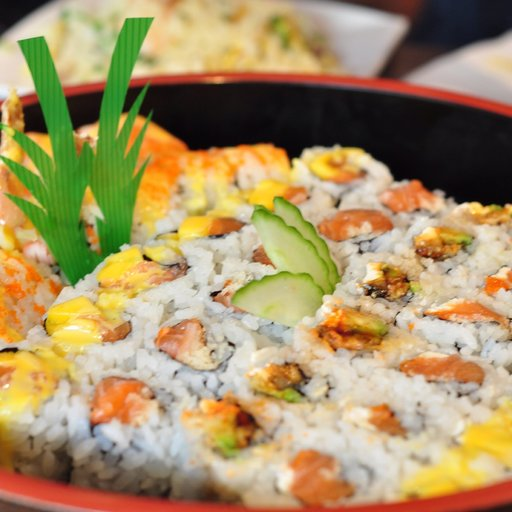

In [33]:
# Visualize an image
import random
from PIL import Image

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image class: {image_class}")
print(f"Image height: {img.height}") 
print(f"Image width: {img.width}")
img

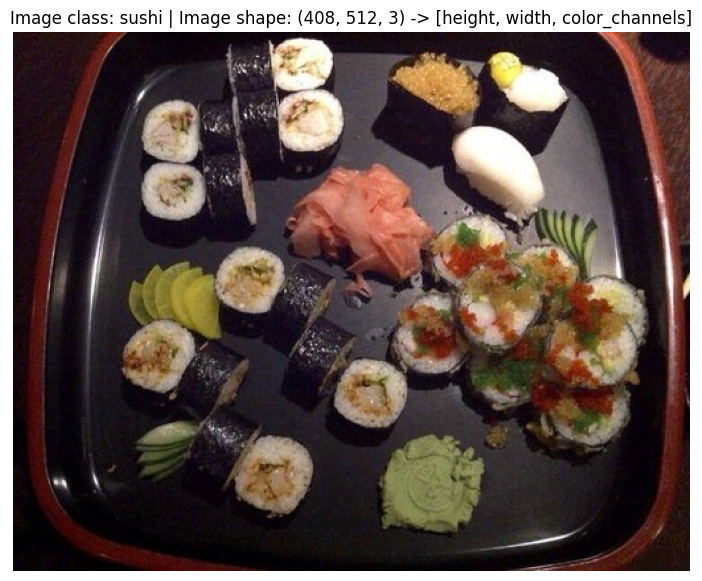

In [8]:
# Do the image visualization with matplotlib
import numpy as np
import matplotlib.pyplot as plt

# Turn the image into an array
img_as_array = np.asarray(img)

# Plot the image with matplotlib
plt.figure(figsize=(10, 7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

We've got some images in our folders.

Now we need to make them compatible with PyTorch by:
1. Transform the data into tensors.
2. Turn the tensor data into a `torch.utils.data.Dataset` and later a `torch.utils.data.DataLoader`.

In [10]:
# 3.1 Transforming data with torchvision.transforms
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [37]:
# Write transform for turning images into tensors
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

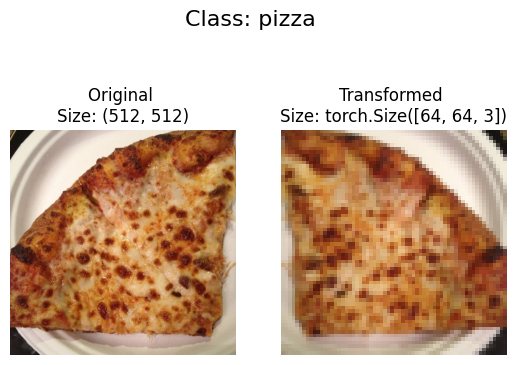

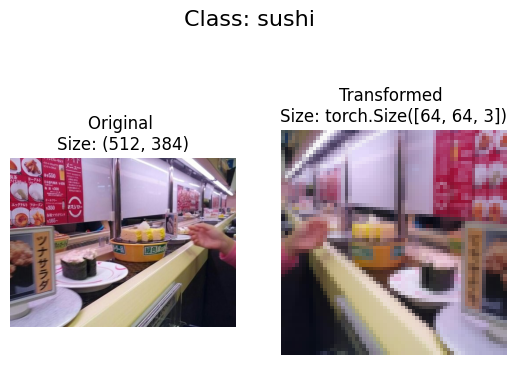

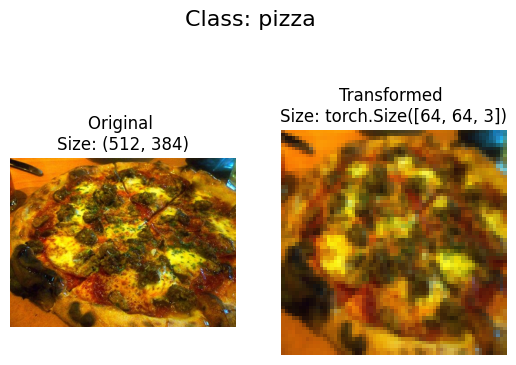

In [38]:
# Write a function to plot transformed images
def plot_transformed_images(image_paths, transform, n=3):
    random_image_paths = random.sample(image_paths, k=n)
    for image_path in random_image_paths:
        with Image.open(image_path) as f:
            fig, ax = plt.subplots(1, 2)
            ax[0].imshow(f) 
            ax[0].set_title(f"Original \nSize: {f.size}")
            ax[0].axis("off")

            # Transform and plot image
            # Note: permute() will change shape of image to suit matplotlib 
            # (PyTorch default is [C, H, W] but Matplotlib is [H, W, C])
            transformed_image = transform(f).permute(1, 2, 0) 
            ax[1].imshow(transformed_image) 
            ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
            ax[1].axis("off")

            fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list, 
                        transform=data_transform, 
                        n=3)

### Load image data using `ImageFolder`

In [39]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data\pizza_steak_sushi\train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data\pizza_steak_sushi\test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [15]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [16]:
# Can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [17]:
# Check the lengths of each dataset
len(train_data), len(test_data)

(225, 75)

In [18]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=1, # how many samples per batch?
                              num_workers=os.cpu_count(), # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=1, 
                             num_workers=os.cpu_count(), 
                             shuffle=False) # don't usually need to shuffle testing data

train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x163800fc260>,
 <torch.utils.data.dataloader.DataLoader at 0x16381260590>)

In [20]:
# How many batches of images are in our data loaders?
print(len(train_dataloader), len(test_dataloader))
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

225 75
Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 3. Recreate `model_0` we built in section 7 of notebook 04.

In [40]:
class TinyVGG(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [41]:
# Pass dummy data through model
dummy_x = torch.rand(size=[1, 3, 64, 64])
model_0(dummy_x.to(device))

tensor([[ 0.0241, -0.0122,  0.0995]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

## 4. Create training and testing functions for `model_0`.

In [42]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):

  # Put the model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0
  
  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item() 

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)
  # Adjust metrics to get average loss and average accuracy per batch
      train_loss = train_loss / len(dataloader)
      train_acc = train_acc / len(dataloader)
      return train_loss, train_acc


In [43]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):

  # Put model in eval mode
  model.eval()

  # Setup the test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)
  
          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()
          
          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
          
  # Adjust metrics to get average loss and accuracy per batch 
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

In [44]:
from tqdm.auto import tqdm

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # Create results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  # Loop through the training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    # Train step
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer)
    # Test step
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)

    # Print out what's happening
    print(f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
    )

    # Update the results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # Return the results dictionary
  return results

c:\Users\afana\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 5. Try training the model you made in exercise 3 for 5, 20 and 50 epochs, what happens to the results?
* Use `torch.optim.Adam()` with a learning rate of 0.001 as the optimizer.

In [50]:
# Train for 5 epochs


NUM_EPOCHS = 5

# Recreate an instance of TinyVGG
model_5 = TinyVGG(input_shape=3,
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_5.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

model_5_results = train(model=model_5, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

 20%|██        | 1/5 [00:15<01:02, 15.72s/it]

Epoch: 1 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0877 | test_acc: 0.4133


 40%|████      | 2/5 [00:30<00:46, 15.46s/it]

Epoch: 2 | train_loss: 0.0044 | train_acc: 0.0044 | test_loss: 1.0837 | test_acc: 0.4133


 60%|██████    | 3/5 [00:46<00:31, 15.64s/it]

Epoch: 3 | train_loss: 0.0054 | train_acc: 0.0000 | test_loss: 1.0813 | test_acc: 0.4133


 80%|████████  | 4/5 [01:01<00:15, 15.36s/it]

Epoch: 4 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.0800 | test_acc: 0.4133


100%|██████████| 5/5 [01:16<00:00, 15.35s/it]

Epoch: 5 | train_loss: 0.0051 | train_acc: 0.0000 | test_loss: 1.0801 | test_acc: 0.4133
Total training time: 76.738 seconds


In [48]:
# Train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_20 = TinyVGG(input_shape=3,
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_20.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

model_20_results = train(model=model_20, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [00:15<04:48, 15.20s/it]

Epoch: 1 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0882 | test_acc: 0.4133


 10%|█         | 2/20 [00:30<04:36, 15.37s/it]

Epoch: 2 | train_loss: 0.0052 | train_acc: 0.0000 | test_loss: 1.0932 | test_acc: 0.4133


 15%|█▌        | 3/20 [00:46<04:23, 15.48s/it]

Epoch: 3 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.1034 | test_acc: 0.4133


 20%|██        | 4/20 [01:01<04:06, 15.40s/it]

Epoch: 4 | train_loss: 0.0058 | train_acc: 0.0000 | test_loss: 1.1066 | test_acc: 0.4133


 25%|██▌       | 5/20 [01:17<03:54, 15.65s/it]

Epoch: 5 | train_loss: 0.0045 | train_acc: 0.0000 | test_loss: 1.1136 | test_acc: 0.2533


 30%|███       | 6/20 [01:33<03:41, 15.80s/it]

Epoch: 6 | train_loss: 0.0046 | train_acc: 0.0000 | test_loss: 1.1177 | test_acc: 0.2533


 35%|███▌      | 7/20 [01:49<03:25, 15.78s/it]

Epoch: 7 | train_loss: 0.0059 | train_acc: 0.0000 | test_loss: 1.1183 | test_acc: 0.2533


 40%|████      | 8/20 [02:05<03:10, 15.88s/it]

Epoch: 8 | train_loss: 0.0058 | train_acc: 0.0000 | test_loss: 1.1168 | test_acc: 0.2533


 45%|████▌     | 9/20 [02:21<02:55, 15.98s/it]

Epoch: 9 | train_loss: 0.0048 | train_acc: 0.0000 | test_loss: 1.1142 | test_acc: 0.2533


 50%|█████     | 10/20 [02:36<02:35, 15.51s/it]

Epoch: 10 | train_loss: 0.0043 | train_acc: 0.0044 | test_loss: 1.1144 | test_acc: 0.2533


 55%|█████▌    | 11/20 [02:50<02:17, 15.28s/it]

Epoch: 11 | train_loss: 0.0056 | train_acc: 0.0000 | test_loss: 1.1136 | test_acc: 0.2533


 60%|██████    | 12/20 [03:05<02:00, 15.02s/it]

Epoch: 12 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.1115 | test_acc: 0.2533


 65%|██████▌   | 13/20 [03:20<01:44, 14.91s/it]

Epoch: 13 | train_loss: 0.0054 | train_acc: 0.0000 | test_loss: 1.1093 | test_acc: 0.2533


 70%|███████   | 14/20 [03:34<01:29, 14.88s/it]

Epoch: 14 | train_loss: 0.0045 | train_acc: 0.0044 | test_loss: 1.1090 | test_acc: 0.2533


 75%|███████▌  | 15/20 [03:49<01:13, 14.72s/it]

Epoch: 15 | train_loss: 0.0045 | train_acc: 0.0044 | test_loss: 1.1103 | test_acc: 0.2533


 80%|████████  | 16/20 [04:03<00:58, 14.71s/it]

Epoch: 16 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.1102 | test_acc: 0.2533


 85%|████████▌ | 17/20 [04:18<00:43, 14.64s/it]

Epoch: 17 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.1090 | test_acc: 0.2533


 90%|█████████ | 18/20 [04:33<00:29, 14.81s/it]

Epoch: 18 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.1071 | test_acc: 0.2533


 95%|█████████▌| 19/20 [04:48<00:14, 14.86s/it]

Epoch: 19 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.1049 | test_acc: 0.2533


100%|██████████| 20/20 [05:03<00:00, 15.18s/it]

Epoch: 20 | train_loss: 0.0052 | train_acc: 0.0000 | test_loss: 1.1024 | test_acc: 0.2533
Total training time: 303.614 seconds


In [51]:
# Train for 50 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 50

# Recreate an instance of TinyVGG
model_50 = TinyVGG(input_shape=3,
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_50.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

model_50_results = train(model=model_50, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/50 [00:00<?, ?it/s]

  2%|▏         | 1/50 [00:15<12:46, 15.64s/it]

Epoch: 1 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0882 | test_acc: 0.4133


  4%|▍         | 2/50 [00:30<12:20, 15.43s/it]

Epoch: 2 | train_loss: 0.0052 | train_acc: 0.0000 | test_loss: 1.0932 | test_acc: 0.4133


  6%|▌         | 3/50 [00:47<12:20, 15.76s/it]

Epoch: 3 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.1034 | test_acc: 0.4133


  8%|▊         | 4/50 [01:02<12:06, 15.80s/it]

Epoch: 4 | train_loss: 0.0058 | train_acc: 0.0000 | test_loss: 1.1066 | test_acc: 0.4133


 10%|█         | 5/50 [01:18<11:41, 15.58s/it]

Epoch: 5 | train_loss: 0.0045 | train_acc: 0.0000 | test_loss: 1.1136 | test_acc: 0.2533


 12%|█▏        | 6/50 [01:33<11:20, 15.47s/it]

Epoch: 6 | train_loss: 0.0046 | train_acc: 0.0000 | test_loss: 1.1177 | test_acc: 0.2533


 14%|█▍        | 7/50 [01:48<11:01, 15.38s/it]

Epoch: 7 | train_loss: 0.0059 | train_acc: 0.0000 | test_loss: 1.1183 | test_acc: 0.2533


 16%|█▌        | 8/50 [02:03<10:37, 15.17s/it]

Epoch: 8 | train_loss: 0.0058 | train_acc: 0.0000 | test_loss: 1.1168 | test_acc: 0.2533


 18%|█▊        | 9/50 [02:18<10:22, 15.18s/it]

Epoch: 9 | train_loss: 0.0048 | train_acc: 0.0000 | test_loss: 1.1142 | test_acc: 0.2533


 20%|██        | 10/50 [02:33<10:06, 15.17s/it]

Epoch: 10 | train_loss: 0.0043 | train_acc: 0.0044 | test_loss: 1.1144 | test_acc: 0.2533


 22%|██▏       | 11/50 [02:48<09:51, 15.16s/it]

Epoch: 11 | train_loss: 0.0056 | train_acc: 0.0000 | test_loss: 1.1136 | test_acc: 0.2533


 24%|██▍       | 12/50 [03:03<09:32, 15.06s/it]

Epoch: 12 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.1115 | test_acc: 0.2533


 26%|██▌       | 13/50 [03:18<09:09, 14.86s/it]

Epoch: 13 | train_loss: 0.0054 | train_acc: 0.0000 | test_loss: 1.1093 | test_acc: 0.2533


 28%|██▊       | 14/50 [03:32<08:52, 14.79s/it]

Epoch: 14 | train_loss: 0.0045 | train_acc: 0.0044 | test_loss: 1.1090 | test_acc: 0.2533


 30%|███       | 15/50 [03:47<08:37, 14.80s/it]

Epoch: 15 | train_loss: 0.0045 | train_acc: 0.0044 | test_loss: 1.1103 | test_acc: 0.2533


 32%|███▏      | 16/50 [04:03<08:32, 15.06s/it]

Epoch: 16 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.1102 | test_acc: 0.2533


 34%|███▍      | 17/50 [04:18<08:15, 15.03s/it]

Epoch: 17 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.1090 | test_acc: 0.2533


 36%|███▌      | 18/50 [04:32<07:55, 14.87s/it]

Epoch: 18 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.1071 | test_acc: 0.2533


 38%|███▊      | 19/50 [04:47<07:38, 14.79s/it]

Epoch: 19 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.1049 | test_acc: 0.2533


 40%|████      | 20/50 [05:02<07:29, 15.00s/it]

Epoch: 20 | train_loss: 0.0052 | train_acc: 0.0000 | test_loss: 1.1024 | test_acc: 0.2533


 42%|████▏     | 21/50 [05:18<07:18, 15.12s/it]

Epoch: 21 | train_loss: 0.0046 | train_acc: 0.0044 | test_loss: 1.1013 | test_acc: 0.2533


 44%|████▍     | 22/50 [05:34<07:15, 15.55s/it]

Epoch: 22 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.1015 | test_acc: 0.2533


 46%|████▌     | 23/50 [05:50<07:01, 15.61s/it]

Epoch: 23 | train_loss: 0.0046 | train_acc: 0.0044 | test_loss: 1.1025 | test_acc: 0.2533


 48%|████▊     | 24/50 [06:04<06:37, 15.27s/it]

Epoch: 24 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1031 | test_acc: 0.2533


 50%|█████     | 25/50 [06:20<06:21, 15.25s/it]

Epoch: 25 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1031 | test_acc: 0.2533


 52%|█████▏    | 26/50 [06:34<06:02, 15.11s/it]

Epoch: 26 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1029 | test_acc: 0.2533


 54%|█████▍    | 27/50 [06:50<05:48, 15.13s/it]

Epoch: 27 | train_loss: 0.0048 | train_acc: 0.0000 | test_loss: 1.1021 | test_acc: 0.2533


 56%|█████▌    | 28/50 [07:05<05:34, 15.22s/it]

Epoch: 28 | train_loss: 0.0048 | train_acc: 0.0000 | test_loss: 1.1008 | test_acc: 0.2533


 58%|█████▊    | 29/50 [07:21<05:22, 15.38s/it]

Epoch: 29 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.1005 | test_acc: 0.2533


 60%|██████    | 30/50 [07:36<05:04, 15.23s/it]

Epoch: 30 | train_loss: 0.0048 | train_acc: 0.0000 | test_loss: 1.0996 | test_acc: 0.2933


 62%|██████▏   | 31/50 [07:50<04:47, 15.12s/it]

Epoch: 31 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.0995 | test_acc: 0.3067


 64%|██████▍   | 32/50 [08:05<04:31, 15.08s/it]

Epoch: 32 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.1002 | test_acc: 0.2800


 66%|██████▌   | 33/50 [08:21<04:18, 15.23s/it]

Epoch: 33 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.1016 | test_acc: 0.2533


 68%|██████▊   | 34/50 [08:36<04:04, 15.27s/it]

Epoch: 34 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1027 | test_acc: 0.2533


 70%|███████   | 35/50 [08:51<03:47, 15.18s/it]

Epoch: 35 | train_loss: 0.0046 | train_acc: 0.0044 | test_loss: 1.1044 | test_acc: 0.2533


 72%|███████▏  | 36/50 [09:06<03:32, 15.17s/it]

Epoch: 36 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1058 | test_acc: 0.2533


 74%|███████▍  | 37/50 [09:22<03:20, 15.40s/it]

Epoch: 37 | train_loss: 0.0045 | train_acc: 0.0044 | test_loss: 1.1078 | test_acc: 0.2533


 76%|███████▌  | 38/50 [09:39<03:07, 15.63s/it]

Epoch: 38 | train_loss: 0.0045 | train_acc: 0.0044 | test_loss: 1.1109 | test_acc: 0.2533


 78%|███████▊  | 39/50 [09:54<02:51, 15.58s/it]

Epoch: 39 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1133 | test_acc: 0.2533


 80%|████████  | 40/50 [10:09<02:35, 15.51s/it]

Epoch: 40 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1152 | test_acc: 0.2533


 82%|████████▏ | 41/50 [10:25<02:18, 15.44s/it]

Epoch: 41 | train_loss: 0.0052 | train_acc: 0.0000 | test_loss: 1.1167 | test_acc: 0.2533


 84%|████████▍ | 42/50 [10:41<02:05, 15.65s/it]

Epoch: 42 | train_loss: 0.0043 | train_acc: 0.0044 | test_loss: 1.1194 | test_acc: 0.2533


 86%|████████▌ | 43/50 [10:57<01:49, 15.66s/it]

Epoch: 43 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1204 | test_acc: 0.2533


 88%|████████▊ | 44/50 [11:12<01:33, 15.56s/it]

Epoch: 44 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1197 | test_acc: 0.2533


 90%|█████████ | 45/50 [11:26<01:16, 15.28s/it]

Epoch: 45 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1183 | test_acc: 0.2533


 92%|█████████▏| 46/50 [11:41<01:00, 15.07s/it]

Epoch: 46 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.1163 | test_acc: 0.2533


 94%|█████████▍| 47/50 [11:56<00:44, 14.91s/it]

Epoch: 47 | train_loss: 0.0052 | train_acc: 0.0000 | test_loss: 1.1141 | test_acc: 0.2533


 96%|█████████▌| 48/50 [12:10<00:29, 14.90s/it]

Epoch: 48 | train_loss: 0.0051 | train_acc: 0.0000 | test_loss: 1.1119 | test_acc: 0.2533


 98%|█████████▊| 49/50 [12:25<00:14, 14.76s/it]

Epoch: 49 | train_loss: 0.0045 | train_acc: 0.0044 | test_loss: 1.1108 | test_acc: 0.2533


100%|██████████| 50/50 [12:39<00:00, 15.20s/it]

Epoch: 50 | train_loss: 0.0051 | train_acc: 0.0000 | test_loss: 1.1096 | test_acc: 0.2533
Total training time: 759.903 seconds


It looks like our model is starting to overfit towards the end (performing far better on the training data than on the testing data).

In order to fix this, we'd have to introduce ways of preventing overfitting.

## 6. Double the number of hidden units in your model and train it for 20 epochs, what happens to the results?

In [52]:
# Double the number of hidden units and train for 20 epochs
torch.manual_seed(42)
torch.cuda.manual_seed(42)

NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_20_2 = TinyVGG(input_shape=3,
                  hidden_units=20, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_20_2.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

model_20_2_results = train(model=model_20_2, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:15<04:50, 15.30s/it]

Epoch: 1 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0904 | test_acc: 0.4133


 10%|█         | 2/20 [00:30<04:29, 14.95s/it]

Epoch: 2 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0945 | test_acc: 0.4133


 15%|█▌        | 3/20 [00:44<04:12, 14.86s/it]

Epoch: 3 | train_loss: 0.0054 | train_acc: 0.0000 | test_loss: 1.0950 | test_acc: 0.4133


 20%|██        | 4/20 [00:59<03:57, 14.85s/it]

Epoch: 4 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.0949 | test_acc: 0.4133


 25%|██▌       | 5/20 [01:14<03:43, 14.91s/it]

Epoch: 5 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0968 | test_acc: 0.4133


 30%|███       | 6/20 [01:29<03:30, 15.03s/it]

Epoch: 6 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.0971 | test_acc: 0.4133


 35%|███▌      | 7/20 [01:44<03:14, 14.93s/it]

Epoch: 7 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.0967 | test_acc: 0.4133


 40%|████      | 8/20 [01:59<02:58, 14.87s/it]

Epoch: 8 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.0954 | test_acc: 0.4133


 45%|████▌     | 9/20 [02:14<02:44, 14.99s/it]

Epoch: 9 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0954 | test_acc: 0.4133


 50%|█████     | 10/20 [02:29<02:31, 15.11s/it]

Epoch: 10 | train_loss: 0.0051 | train_acc: 0.0000 | test_loss: 1.0950 | test_acc: 0.4133


 55%|█████▌    | 11/20 [02:44<02:14, 14.98s/it]

Epoch: 11 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0957 | test_acc: 0.4133


 60%|██████    | 12/20 [02:59<01:59, 14.91s/it]

Epoch: 12 | train_loss: 0.0051 | train_acc: 0.0000 | test_loss: 1.0962 | test_acc: 0.4133


 65%|██████▌   | 13/20 [03:14<01:44, 14.96s/it]

Epoch: 13 | train_loss: 0.0051 | train_acc: 0.0000 | test_loss: 1.0966 | test_acc: 0.4133


 70%|███████   | 14/20 [03:29<01:29, 14.88s/it]

Epoch: 14 | train_loss: 0.0048 | train_acc: 0.0044 | test_loss: 1.0965 | test_acc: 0.4133


 75%|███████▌  | 15/20 [03:43<01:14, 14.86s/it]

Epoch: 15 | train_loss: 0.0048 | train_acc: 0.0044 | test_loss: 1.0961 | test_acc: 0.4133


 80%|████████  | 16/20 [03:58<00:59, 14.87s/it]

Epoch: 16 | train_loss: 0.0048 | train_acc: 0.0044 | test_loss: 1.0954 | test_acc: 0.4133


 85%|████████▌ | 17/20 [04:13<00:44, 14.82s/it]

Epoch: 17 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0952 | test_acc: 0.4133


 90%|█████████ | 18/20 [04:28<00:29, 14.94s/it]

Epoch: 18 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.0944 | test_acc: 0.4133


 95%|█████████▌| 19/20 [04:43<00:14, 14.88s/it]

Epoch: 19 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0938 | test_acc: 0.4133


100%|██████████| 20/20 [04:58<00:00, 14.91s/it]

Epoch: 20 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0934 | test_acc: 0.4133
Total training time: 298.212 seconds


It looks like the model is still overfitting, even when changing the number of hidden units.

To fix this, we'd have to look at ways to prevent overfitting with our model.

## 7. Double the data you're using with your model from step 6 and train it for 20 epochs, what happens to the results?
* **Note:** You can use the [custom data creation notebook](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/extras/04_custom_data_creation.ipynb) to scale up your Food101 dataset.
* You can also find the [already formatted double data (20% instead of 10% subset) dataset on GitHub](https://github.com/mrdbourke/pytorch-deep-learning/blob/main/data/pizza_steak_sushi_20_percent.zip), you will need to write download code like in exercise 2 to get it into this notebook.

In [53]:
# Download 20% data for Pizza/Steak/Sushi from GitHub
import requests
import zipfile
from pathlib import Path

# Setup path to data folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi_20_percent"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
    print(f"{image_path} directory exists.")
else:
    print(f"Did not find {image_path} directory, creating one...")
    image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak, sushi data
with open(data_path / "pizza_steak_sushi_20_percent.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")
    print("Downloading pizza, steak, sushi 20% data...")
    f.write(request.content)

# Unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi_20_percent.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi 20% data...")
    zip_ref.extractall(image_path)

Did not find data\pizza_steak_sushi_20_percent directory, creating one...
Unzipping pizza, steak, sushi 20% data...


In [54]:
# See how many images we have
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data\pizza_steak_sushi_20_percent'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\test'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\pizza'.
There are 0 directories and 58 images in 'data\pizza_steak_sushi_20_percent\test\steak'.
There are 0 directories and 46 images in 'data\pizza_steak_sushi_20_percent\test\sushi'.
There are 3 directories and 0 images in 'data\pizza_steak_sushi_20_percent\train'.
There are 0 directories and 154 images in 'data\pizza_steak_sushi_20_percent\train\pizza'.
There are 0 directories and 146 images in 'data\pizza_steak_sushi_20_percent\train\steak'.
There are 0 directories and 150 images in 'data\pizza_steak_sushi_20_percent\train\sushi'.


Excellent, we now have double the training and testing images...

In [55]:
# Create the train and test paths
train_data_20_percent_path = image_path / "train"
test_data_20_percent_path = image_path / "test"

train_data_20_percent_path, test_data_20_percent_path

(WindowsPath('data/pizza_steak_sushi_20_percent/train'),
 WindowsPath('data/pizza_steak_sushi_20_percent/test'))

In [56]:
# Turn the 20 percent datapaths into Datasets and DataLoaders
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader

simple_transform = transforms.Compose([
  transforms.Resize((64, 64)),
  transforms.ToTensor()
])

# Create datasets
train_data_20_percent = ImageFolder(train_data_20_percent_path,
                                    transform=simple_transform)

test_data_20_percent = ImageFolder(test_data_20_percent_path,
                                   transform=simple_transform)

# Create dataloaders
train_dataloader_20_percent = DataLoader(train_data_20_percent, 
                                         batch_size=32,
                                         num_workers=os.cpu_count(),
                                         shuffle=True)

test_dataloader_20_percent = DataLoader(test_data_20_percent,
                                        batch_size=32,
                                        num_workers=os.cpu_count(),
                                        shuffle=False)

In [57]:
# Train a model with increased amount of data
torch.manual_seed(42)
torch.cuda.manual_seed(42)
NUM_EPOCHS = 20

# Recreate an instance of TinyVGG
model_4 = TinyVGG(input_shape=3,
                  hidden_units=20, 
                  output_shape=len(train_data.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_4.parameters(),
                             lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

model_4_results = train(model=model_4, 
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)
# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  5%|▌         | 1/20 [00:15<04:48, 15.18s/it]

Epoch: 1 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0904 | test_acc: 0.4133


 10%|█         | 2/20 [00:30<04:30, 15.01s/it]

Epoch: 2 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0945 | test_acc: 0.4133


 15%|█▌        | 3/20 [00:45<04:17, 15.12s/it]

Epoch: 3 | train_loss: 0.0054 | train_acc: 0.0000 | test_loss: 1.0950 | test_acc: 0.4133


 20%|██        | 4/20 [01:00<03:59, 14.98s/it]

Epoch: 4 | train_loss: 0.0053 | train_acc: 0.0000 | test_loss: 1.0949 | test_acc: 0.4133


 25%|██▌       | 5/20 [01:14<03:43, 14.90s/it]

Epoch: 5 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0968 | test_acc: 0.4133


 30%|███       | 6/20 [01:29<03:27, 14.84s/it]

Epoch: 6 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.0971 | test_acc: 0.4133


 35%|███▌      | 7/20 [01:44<03:12, 14.82s/it]

Epoch: 7 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.0967 | test_acc: 0.4133


 40%|████      | 8/20 [01:59<02:57, 14.80s/it]

Epoch: 8 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.0954 | test_acc: 0.4133


 45%|████▌     | 9/20 [02:13<02:42, 14.80s/it]

Epoch: 9 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0954 | test_acc: 0.4133


 50%|█████     | 10/20 [02:29<02:29, 14.94s/it]

Epoch: 10 | train_loss: 0.0051 | train_acc: 0.0000 | test_loss: 1.0950 | test_acc: 0.4133


 55%|█████▌    | 11/20 [02:44<02:14, 14.94s/it]

Epoch: 11 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0957 | test_acc: 0.4133


 60%|██████    | 12/20 [02:58<01:59, 14.89s/it]

Epoch: 12 | train_loss: 0.0051 | train_acc: 0.0000 | test_loss: 1.0962 | test_acc: 0.4133


 65%|██████▌   | 13/20 [03:13<01:43, 14.85s/it]

Epoch: 13 | train_loss: 0.0051 | train_acc: 0.0000 | test_loss: 1.0966 | test_acc: 0.4133


 70%|███████   | 14/20 [03:28<01:29, 14.87s/it]

Epoch: 14 | train_loss: 0.0048 | train_acc: 0.0044 | test_loss: 1.0965 | test_acc: 0.4133


 75%|███████▌  | 15/20 [03:43<01:14, 14.81s/it]

Epoch: 15 | train_loss: 0.0048 | train_acc: 0.0044 | test_loss: 1.0961 | test_acc: 0.4133


 80%|████████  | 16/20 [03:57<00:59, 14.80s/it]

Epoch: 16 | train_loss: 0.0048 | train_acc: 0.0044 | test_loss: 1.0954 | test_acc: 0.4133


 85%|████████▌ | 17/20 [04:12<00:44, 14.78s/it]

Epoch: 17 | train_loss: 0.0049 | train_acc: 0.0000 | test_loss: 1.0952 | test_acc: 0.4133


 90%|█████████ | 18/20 [04:27<00:29, 14.79s/it]

Epoch: 18 | train_loss: 0.0047 | train_acc: 0.0044 | test_loss: 1.0944 | test_acc: 0.4133


 95%|█████████▌| 19/20 [04:42<00:14, 14.76s/it]

Epoch: 19 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0938 | test_acc: 0.4133


100%|██████████| 20/20 [04:57<00:00, 14.85s/it]

Epoch: 20 | train_loss: 0.0050 | train_acc: 0.0000 | test_loss: 1.0934 | test_acc: 0.4133
Total training time: 297.080 seconds


## 8. Make a prediction on your own custom image of pizza/steak/sushi (you could even download one from the internet) with your trained model from exercise 7 and share your prediction.
* Does the model you trained in exercise 7 get it right?
* If not, what do you think you could do to improve it?

In [96]:
# Setup custom image path
custom_image_path = "pizza.jpg"


In [97]:
import torchvision

# Read in custom image
custom_image_uint8 = torchvision.io.read_image(custom_image_path)

# Print out image data
print(f"Custom image tensor:\n{custom_image_uint8}\n")
print(f"Custom image shape: {custom_image_uint8.shape}\n")
print(f"Custom image dtype: {custom_image_uint8.dtype}")

Custom image tensor:
tensor([[[167, 191, 176,  ..., 185, 184, 183],
         [156, 160, 162,  ..., 185, 184, 183],
         [154, 139, 151,  ..., 185, 184, 184],
         ...,
         [229, 228, 231,  ...,  73,  53,  38],
         [237, 237, 243,  ...,  53,  25,  13],
         [242, 242, 248,  ...,  49,  17,   9]],

        [[159, 183, 164,  ..., 156, 155, 154],
         [148, 152, 152,  ..., 156, 155, 154],
         [148, 134, 144,  ..., 156, 155, 155],
         ...,
         [255, 254, 252,  ...,  60,  39,  24],
         [252, 252, 254,  ...,  40,  14,   2],
         [252, 252, 253,  ...,  36,   6,   0]],

        [[172, 194, 174,  ..., 124, 123, 122],
         [161, 163, 160,  ..., 124, 123, 122],
         [158, 141, 151,  ..., 124, 123, 123],
         ...,
         [255, 255, 253,  ...,  52,  36,  21],
         [247, 247, 250,  ...,  32,  10,   0],
         [244, 244, 247,  ...,  28,   2,   0]]], dtype=torch.uint8)

Custom image shape: torch.Size([3, 1280, 960])

Custom image dtyp

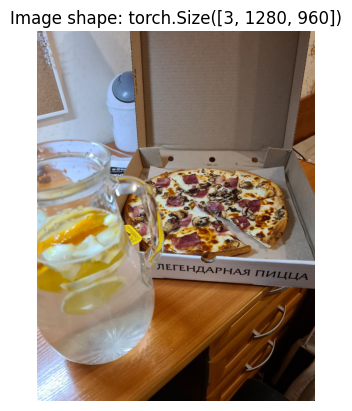

In [98]:
# Plot custom image
plt.imshow(custom_image_uint8.permute(1, 2, 0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error
plt.title(f"Image shape: {custom_image_uint8.shape}")
plt.axis(False);

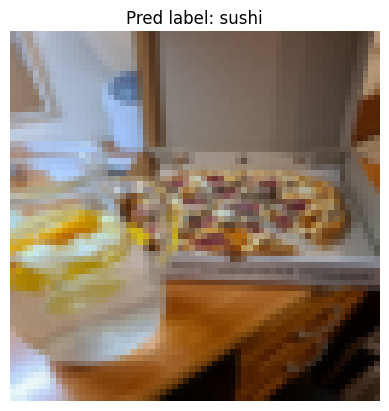

In [99]:
model_4.eval()
with torch.inference_mode():
  
  # Get image pixels into float + between 0 and 1
  custom_image_uint8 = custom_image_uint8 / 255.

  # Resize image to 64x64
  resize = transforms.Resize((64, 64))
  custom_image_uint8 = resize(custom_image_uint8)

  # Turn image in single batch and pass to target device
  batch = custom_image_uint8.unsqueeze(0).to(device)

  # Predict on image
  y_pred_logit = model_4(batch) 

  # Convert pred logit to pred label
  # pred_label = torch.argmax(torch.softmax(y_pred_logit, dim=1), dim=1)
  pred_label = torch.argmax(y_pred_logit, dim=1) # get same results as above without torch.softmax

# Plot the image and prediction
plt.imshow(custom_image_uint8.permute(1, 2, 0))
plt.title(f"Pred label: {class_names[pred_label]}")
plt.axis(False);